## Description : 
This document will be all about practicing ML Models

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import time
import plotly.express as pe
import plotly.offline as pyo
import plotly.graph_objects as go

from datetime import datetime
#
os.chdir('../')

In [2]:
from lib import dataprocess as dp
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dp.process_downloaded_data('Madison','wunderground','pws','2021')


True

As we discussed in the last meeting, I would suggest the following steps in constructing the training dataset from the surface measurements.

<li>Please conduct basic QC screening, delete sites with extreme values as well as long-term missing data </li>
<li>Each location: Estimate multi-year average T/moisture/etc at hourly (local standard time)for each month. </li>
<li>Check the diurnal cycles among all sites in each domain, and see whether there are additional outliers that require further scrutiny </li>


In [4]:
dp.process_downloaded_data('Madison','wunderground','pws','2022')


True

In [5]:
df = pd.read_csv('data/Madison_2021/master_Madison_pws_.csv')
df = dp.process_wunder(df)

### Finding stations with missing months

In [114]:
clean_stations(df)

Original Stations : 170
Incomplete Stations : 84
Final Stations : 86


(           station            beg_time  Unnamed: 0         epoch   latitude  \
 0       KWICOTTA13 2021-01-01 00:00:00         0.0  1.609484e+09  43.057156   
 1       KWICOTTA13 2021-01-01 01:00:00         1.0  1.609488e+09  43.057156   
 2       KWICOTTA13 2021-01-01 02:00:00         2.0  1.609492e+09  43.057156   
 3       KWICOTTA13 2021-01-01 03:00:00         3.0  1.609495e+09  43.057156   
 4       KWICOTTA13 2021-01-01 04:00:00         4.0  1.609499e+09  43.057156   
 ...            ...                 ...         ...           ...        ...   
 998512  KWIWINDS10 2021-12-30 19:00:00    998640.0  1.640916e+09  43.206000   
 998513  KWIWINDS10 2021-12-30 20:00:00    998641.0  1.640919e+09  43.206000   
 998514  KWIWINDS10 2021-12-30 21:00:00    998642.0  1.640923e+09  43.206000   
 998515  KWIWINDS10 2021-12-30 22:00:00    998643.0  1.640926e+09  43.206000   
 998516  KWIWINDS10 2021-12-30 23:00:00    998644.0  1.640930e+09  43.206000   
 
         longitude  humidityAvg  tempe

In [6]:
def clean_stations(df):
    ''' This function adds new month column, removes stations with missing months'''
    
    df['month'] = df['beg_time'].apply(lambda x : x.month)
    stations = df.station.unique()
    incomplete_stations = []

    for stat in stations:
        months = df[df.station==stat].month.unique()
        if len(months)<12:
            incomplete_stations.append(stat)

    print(f'Original Stations : {len(stations)}')
    print(f'Incomplete Stations : {len(incomplete_stations)}')

    complete_stations = list(set(stations)-set(incomplete_stations))
    print(f'Final Stations : {len(complete_stations)}')
    
    return df,complete_stations

In [52]:
def temp_aggregator(df,complete_stations,station_index=0):
    ''' This functions averages the temperature values by month for station of concern'''
    
    station_1 = df[df.station == complete_stations[station_index]]
    station_1 = station_1.assign(hour='')
    station_1.loc[:,'hour'] = station_1['beg_time'].apply(lambda x : x.hour)
    temp_mean = station_1.groupby(['month','hour']).mean()
    station_identifier = df.station.unique()[0]
    return temp_mean,station_identifier

In [112]:
def plot_diurnal(temp_mean,station_id):
    ''' Function to plot the diurnal cycle '''
    plt.figure(figsize=(8,6))
    for i in range(1,13):
        plt.plot(temp_mean.loc[i]['temperature'],label='Month '+ str(i))

    plt.legend(loc='upper right')
    plt.xlabel('Hour of Day')
    plt.ylabel('Temperature')
    plt.title(station_id)
    
    return

In [107]:
# from plotly.subplots import make_subplots

# fig = make_subplots(rows =2, cols=2,subplot_titles=[])
# fig.add_trace(go.Scatter(y = temp_mean.loc[1]['temperature']),row=1,col=1,)
# fig.data[-1].name = 'Month 1'

# fig.add_trace(go.Scatter(y = temp_mean.loc[2]['temperature']),row=1,col=1,)
# fig.data[-1].name = 'Month 2'

# # fig.add_trace(go.Scatter(x = [1,2,3],y=[4,5,6]),row=1,col=2)

# fig.show()


# for i in range(10):
#     temp_mean,station_id = temp_aggregator(df,complete_stations,station_index=i)
#     plot_diurnal(temp_mean,station_id)

# def plot_diurnal_plotly(temp_mean,station_id,num_stations = 18):
# num_stations = 18
# fig = make_subplots(rows =int(num_stations/3), cols=3,subplot_titles=[])

# for i in range(num_stations):
#     temp_mean,station_id = temp_aggregator(df,complete_stations,station_index=i)
    
#     for month_index in range(1,13):
#         fig.add_trace(go.Scatter(y = temp_mean.loc[month_index]['temperature']),row=i/+1,col=i+1,)
# # fig.data[-1].name = 'Month 1'
        
    

#     for 
    

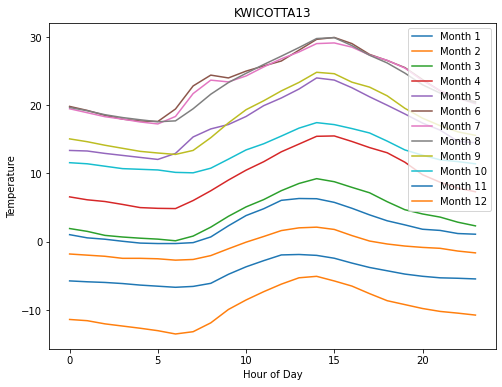

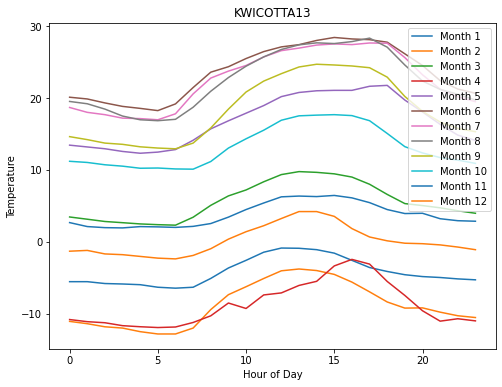

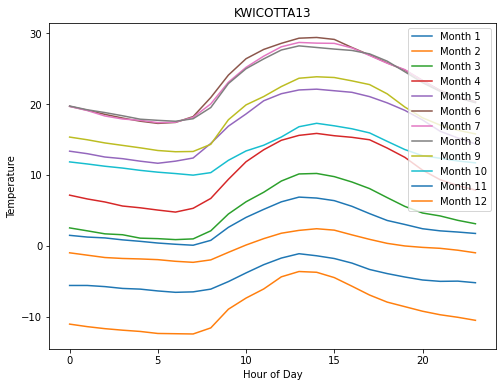

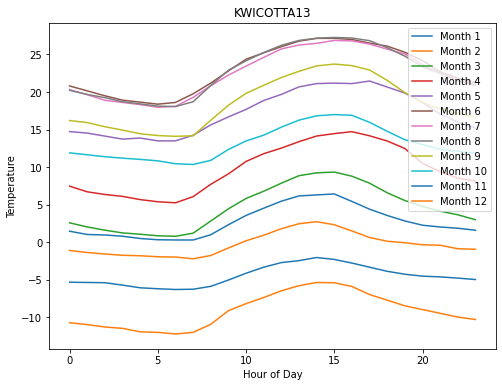

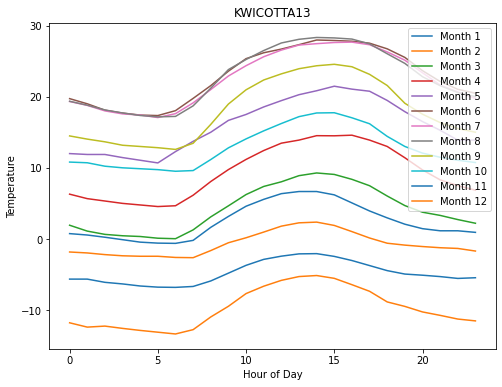

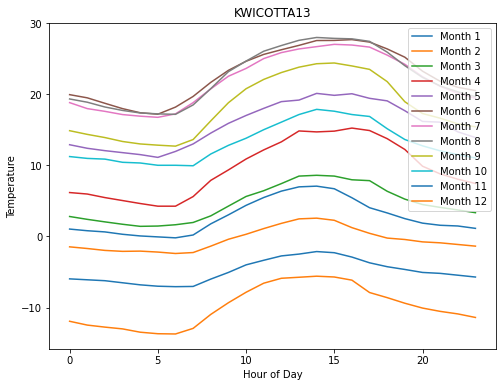

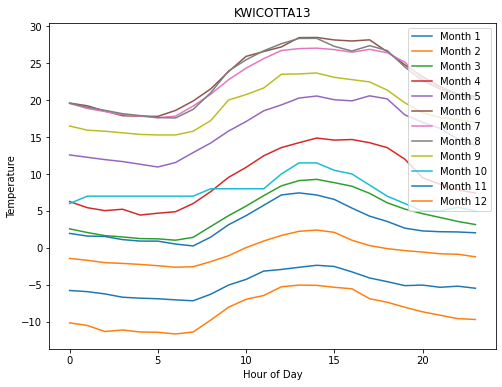

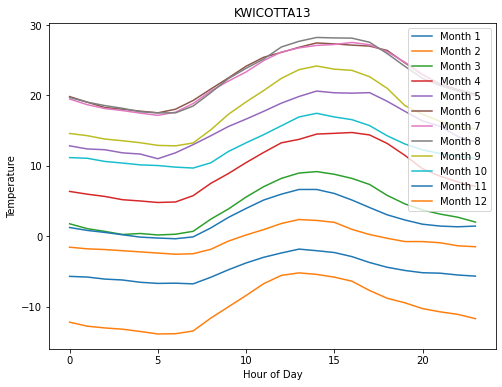

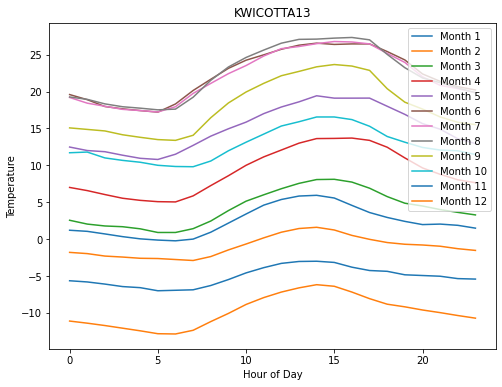

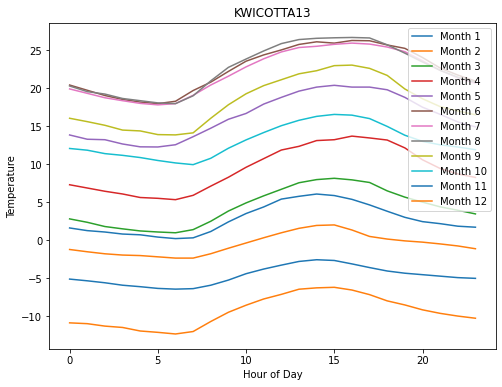

In [113]:
for i in range(10):
    temp_mean,station_id = temp_aggregator(df,complete_stations,station_index=i)
    plot_diurnal(temp_mean,station_id)

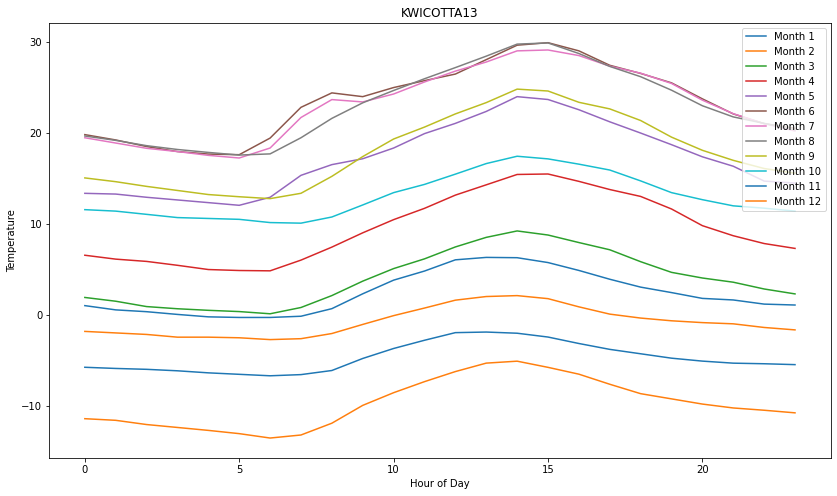

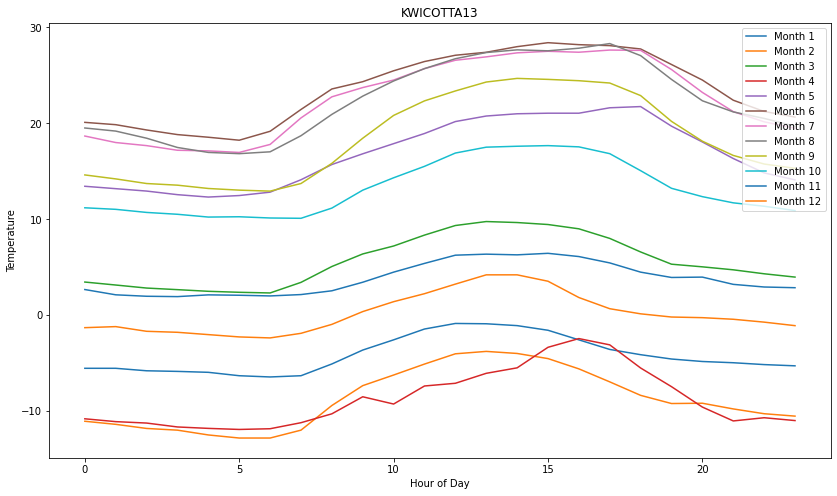

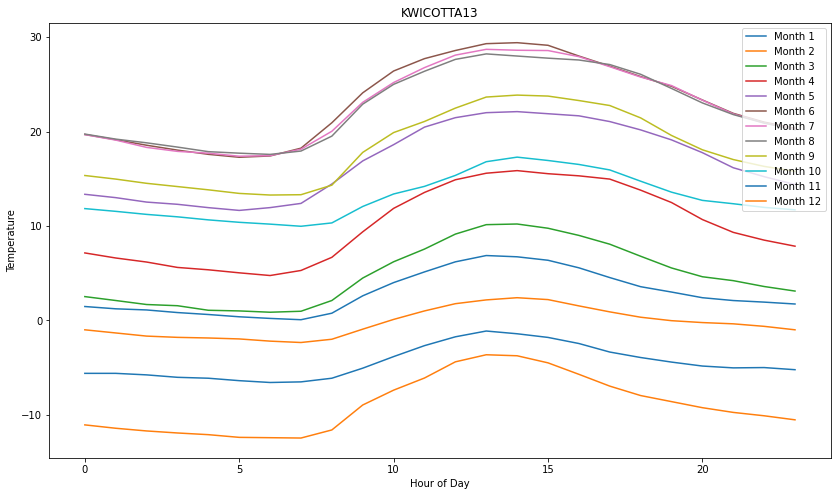

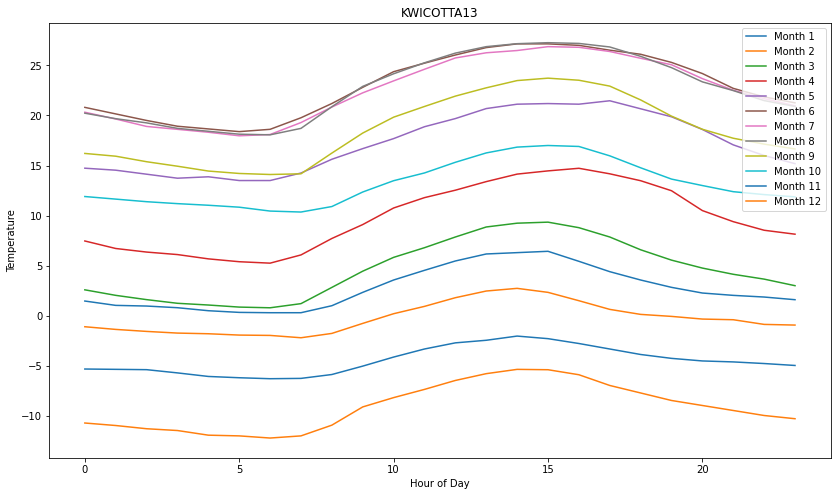

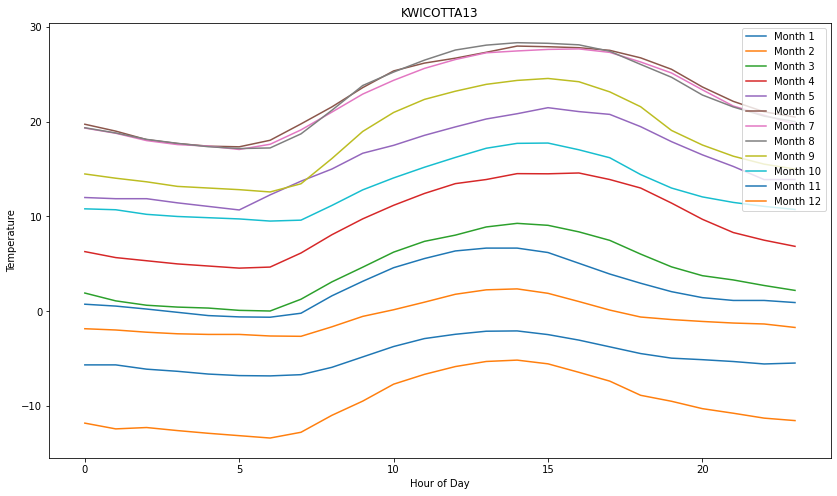

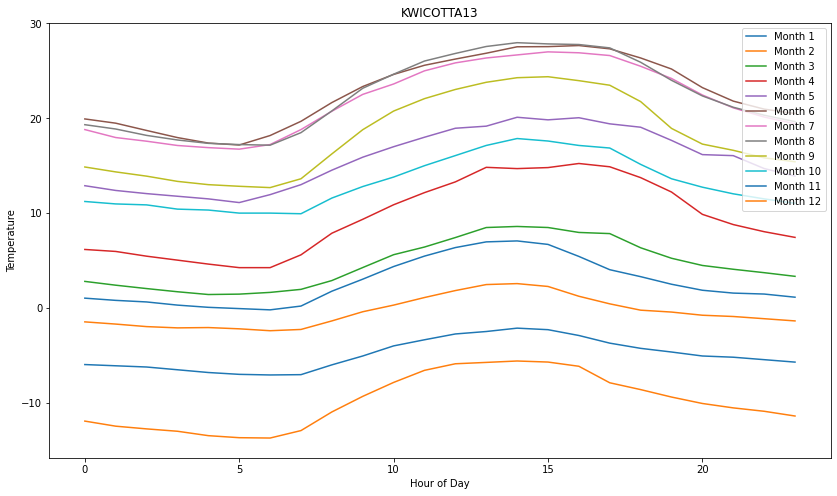

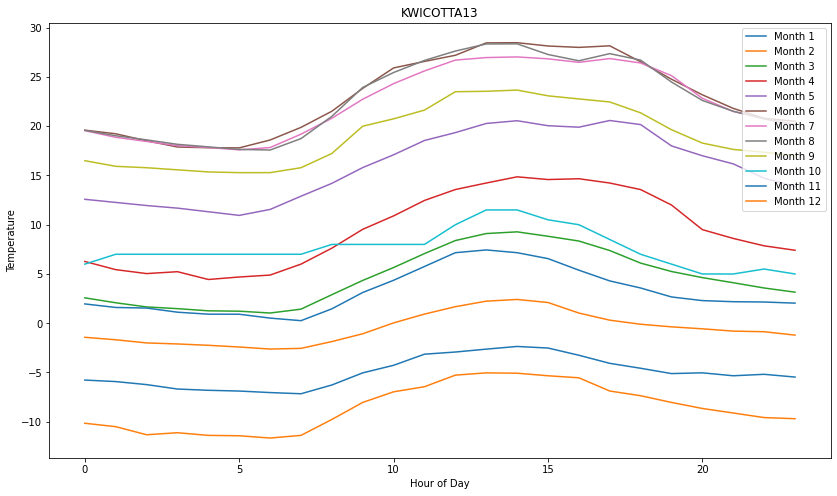

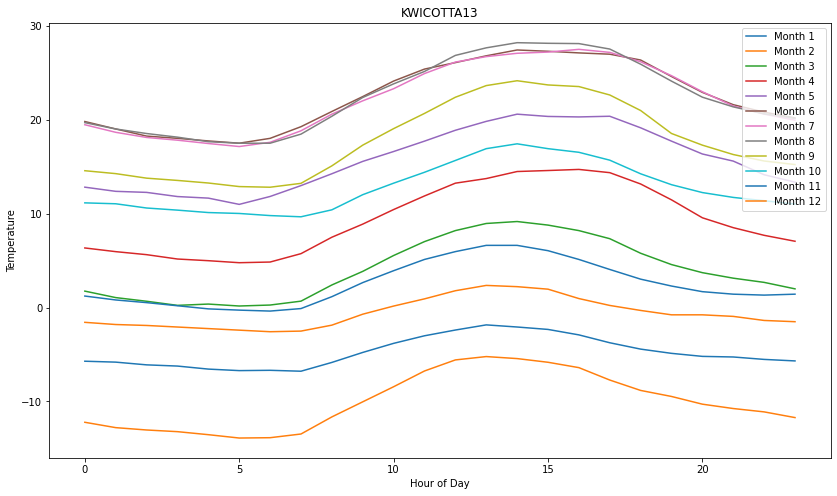

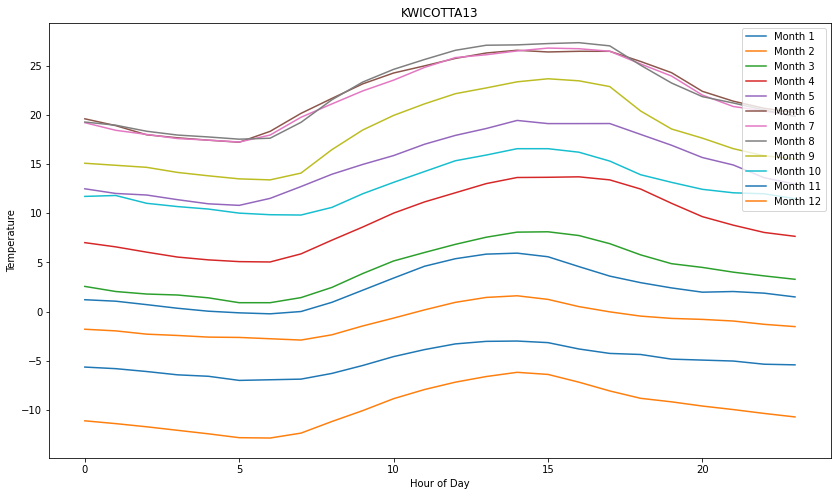

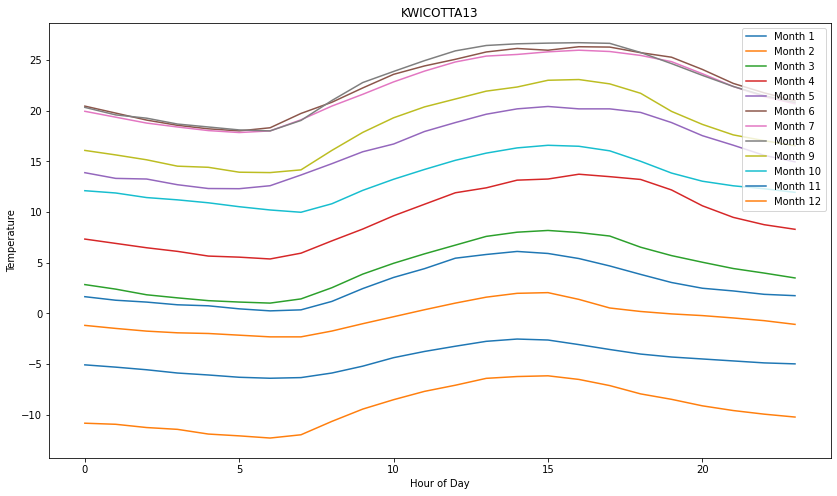

In [56]:
for i in range(10):
    temp_mean,station_id = temp_aggregator(df,complete_stations,station_index=i)
    plot_diurnal(temp_mean,station_id)

In [8]:
from math import radians, cos, sin, asin, sqrt, degrees, atan2

x = df.groupby(['latitude','longitude']).size().reset_index()

def distance_haversine(p1, p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Haversine
    formula: 
        a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
                        _   ____
        c = 2 ⋅ atan2( √a, √(1−a) )
        d = R ⋅ c

    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
            note that angles need to be in radians to pass to trig functions!
    """
    lat1, lon1 = p1
    lat2, lon2 = p2

    R = 6371 # km - earths's radius

    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) # 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c
    return d

In [10]:
distance_haversine(x.iloc[0].values[:2],x.iloc[4].values[:2])

8.845493292884914

In [21]:
con_df = df[df.station=='KWICOTTA13']
con_df.loc[:,'predicted'] = 0.0
# con_df.loc[:, 'predicted'] = 0.0
con_df


/var/folders/qr/fds_zg7j76g51mq0zmqdqfnc0000gn/T/ipykernel_90019/2953242346.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



station            beg_time  Unnamed: 0         epoch   latitude  \
0     KWICOTTA13 2021-01-01 00:00:00         0.0  1.609484e+09  43.057156   
1     KWICOTTA13 2021-01-01 01:00:00         1.0  1.609488e+09  43.057156   
2     KWICOTTA13 2021-01-01 02:00:00         2.0  1.609492e+09  43.057156   
3     KWICOTTA13 2021-01-01 03:00:00         3.0  1.609495e+09  43.057156   
4     KWICOTTA13 2021-01-01 04:00:00         4.0  1.609499e+09  43.057156   
...          ...                 ...         ...           ...        ...   
4716  KWICOTTA13 2021-12-30 19:00:00      4717.0  1.640916e+09  43.057156   
4717  KWICOTTA13 2021-12-30 20:00:00      4718.0  1.640920e+09  43.057156   
4718  KWICOTTA13 2021-12-30 21:00:00      4719.0  1.640923e+09  43.057156   
4719  KWICOTTA13 2021-12-30 22:00:00      4720.0  1.640927e+09  43.057156   
4720  KWICOTTA13 2021-12-30 23:00:00      4721.0  1.640930e+09  43.057156   

      longitude  humidityAvg  temperature  windspeed  dewpt  heatindex  \
0    -89.244202         90.0         -9.0        6.0  -10.0       -9.0   
1    -89.244202         90.0         -8.0        2.0  -10.0       -8.0   
2    -89.244202         90.0         -8.0        1.0  -10.0       -8.0   
3    -89.244202         90.0         -9.0        2.0  -10.0       -8.0   
4    -89.244202         90.0         -9.0        2.0  -10.0       -9.0   
...         ...          ...          ...        ...    ...        ...   
4716 -89.244202         92.0         -2.0        4.0   -3.0       -2.0   
4717 -89.244202         93.0         -2.0        7.0   -3.0       -2.0   
4718 -89.244202         93.0         -2.0        5.0   -3.0       -2.0   
4719 -89.244202         93.0         -2.0        6.0   -3.0       -2.0   
4720 -89.244202         93.0         -2.0        5.0   -3.0       -2.0   

      precipRate  day_of_year  predicted  
0            0.0            1        0.0  
1            0.0            1        0.0  
2            0.0            1        0.0  
3            0.0            1        0.0  
4            0.0            1        0.0  
...          ...          ...        ...  
4716         0.0          364        0.0  
4717         0.0          364        0.0  
4718         0.0          364        0.0  
4719         0.0          364        0.0  
4720         0.0          364        0.0  

[4721 rows x 14 columns]

In [10]:
# # for _,group in grouped_data:
# #     coordinates = group[['latitude', 'longitude']].values
# #     nn_model = NearestNeighbors(n_neighbors=4)
# #     nn_model.fit(coordinates)
# #     distances, indices = nn_model.kneighbors(coordinates, n_neighbors=4)
# #     nearest_indices = indices[:, 1:]  
    
# #     for i, row in group.iterrows():
# #         current_lat, current_lon = row['latitude'], row['longitude']
# # #         print(i)
# #         group.iloc[nearest_indices[i]]['temperature']
# #         predicted_temperature = nearest_temperatures.mean()
        
# #         df.at[i, 'predicted_temperature'] = predicted_temperature

# temp_data = grouped_data.head(25)
# coords = temp_data[['latitude','longitude']].values
# nn_model = NearestNeighbors(n_neighbors=4)
# nn_model.fit(coords)

# distances, indices = nn_model.kneighbors(coordinates, n_neighbors=4)

# grouped_data.get_group('KWICOTTA13')[['latitude', 'longitude']]

for group in grouped_data:
    print(group[0])

KWICOTTA13
KWIFITCH21
KWIFITCH30
KWIFITCH35
KWIFITCH38
KWIFITCH40
KWIFITCH41
KWIFITCH42
KWIFITCH46
KWIFITCH6
KWIFITCH8
KWIMADIS1
KWIMADIS104
KWIMADIS114
KWIMADIS118
KWIMADIS119
KWIMADIS120
KWIMADIS130
KWIMADIS132
KWIMADIS134
KWIMADIS138
KWIMADIS151
KWIMADIS162
KWIMADIS175
KWIMADIS18
KWIMADIS187
KWIMADIS194
KWIMADIS195
KWIMADIS196
KWIMADIS198
KWIMADIS199
KWIMADIS201
KWIMADIS205
KWIMADIS208
KWIMADIS212
KWIMADIS214
KWIMADIS215
KWIMADIS222
KWIMADIS223
KWIMADIS226
KWIMADIS233
KWIMADIS237
KWIMADIS238
KWIMADIS239
KWIMADIS242
KWIMADIS249
KWIMADIS259
KWIMADIS262
KWIMADIS266
KWIMADIS270
KWIMADIS273
KWIMADIS278
KWIMADIS279
KWIMADIS283
KWIMADIS284
KWIMADIS287
KWIMADIS288
KWIMADIS290
KWIMADIS292
KWIMADIS293
KWIMADIS294
KWIMADIS295
KWIMADIS298
KWIMADIS301
KWIMADIS306
KWIMADIS308
KWIMADIS309
KWIMADIS310
KWIMADIS311
KWIMADIS312
KWIMADIS313
KWIMADIS314
KWIMADIS324
KWIMADIS328
KWIMADIS33
KWIMADIS331
KWIMADIS332
KWIMADIS333
KWIMADIS334
KWIMADIS335
KWIMADIS336
KWIMADIS338
KWIMADIS340
KWIMADIS342
KWIMADIS3

In [7]:
df.head()

station            beg_time  Unnamed: 0         epoch   latitude  \
0  KWICOTTA13 2021-01-01 00:00:00         0.0  1.609484e+09  43.057156   
1  KWICOTTA13 2021-01-01 01:00:00         1.0  1.609488e+09  43.057156   
2  KWICOTTA13 2021-01-01 02:00:00         2.0  1.609492e+09  43.057156   
3  KWICOTTA13 2021-01-01 03:00:00         3.0  1.609495e+09  43.057156   
4  KWICOTTA13 2021-01-01 04:00:00         4.0  1.609499e+09  43.057156   

   longitude  humidityAvg  temperature  windspeed  dewpt  heatindex  \
0 -89.244202         90.0         -9.0        6.0  -10.0       -9.0   
1 -89.244202         90.0         -8.0        2.0  -10.0       -8.0   
2 -89.244202         90.0         -8.0        1.0  -10.0       -8.0   
3 -89.244202         90.0         -9.0        2.0  -10.0       -8.0   
4 -89.244202         90.0         -9.0        2.0  -10.0       -9.0   

   precipRate  day_of_year  predicted_temperature  
0         0.0            1                    0.0  
1         0.0            1                    0.0  
2         0.0            1                    0.0  
3         0.0            1                    0.0  
4         0.0            1                    0.0

In [ ]:
concerned_df = df[df.station =='KWICOTTA13']
pe.line(concerned_df,x = 'beg_time',y= ['temperature','predicted_temperature'])

In [8]:
grouped_data = df.groupby(['latitude','longitude'])

In [10]:
grouped_data.values

AttributeError: 'DataFrameGroupBy' object has no attribute 'values'